In [1]:
import os
import time
from datetime import datetime
import yaml
import numpy as np
from matplotlib import pyplot as plt

def data_processing(core_num:int = 16, node_num:int = 3, data_portion:float = 1.0):
    import re
    import json
    from pyspark.sql import SparkSession
    from operator import add
    from pyspark.sql.types import StructType, StructField, StringType, LongType
    from pyspark.sql.functions import udf, col, size
    from pyspark.sql.types import FloatType, ArrayType
    import re

    spark_session_name = f"scale_test_{core_num}_{node_num}_{data_portion}"
    spark_session = SparkSession.builder\
            .master("spark://spark-master:7077") \
            .appName(spark_session_name)\
            .config("spark.dynamicAllocation.enabled", False)\
            .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
            .config("spark.executor.instances", node_num)\
            .config("spark.executor.cores", core_num)\
            .config("spark.cores.max", core_num*node_num)\
            .config("spark.driver.port",9999)\
            .config("spark.blockManager.port",10005)\
            .getOrCreate()
    
    # RDD API
    spark_context = spark_session.sparkContext
    spark_context.setLogLevel("ERROR")

    DATA_PATH = 'data/reddit.json'
    lines = spark_context.textFile(f"hdfs://spark-master:9000/{DATA_PATH}")
    sampled_lines = lines.sample(withReplacement=False, fraction=data_portion, seed=42)
    
    # Parse each JSON line into a Python dict
    parsed_rdd = sampled_lines.map(lambda line: json.loads(line))

    custom_schema = StructType([
        StructField("content", StringType(), True),          # Comment text
        StructField("summary", StringType(), True),     # Timestamp
        StructField("author", StringType(), True),        # Username
        StructField("subreddit", StringType(), True)      # Subreddit name
    ])
    
    df = spark_session.createDataFrame(parsed_rdd, schema=custom_schema)

    tech_tickers = [
        "AAPL",  # Apple Inc.
        "MSFT",  # Microsoft Corporation
        "GOOGL", "GOOG",  # Alphabet Inc. (Google)
        "AMZN",  # Amazon.com Inc.
        "META",  # Meta Platforms Inc. (Facebook)
        "NVDA",  # NVIDIA Corporation
        "TSLA",  # Tesla Inc.
        "INTC",  # Intel Corporation
        "AMD",  # Advanced Micro Devices Inc.
        "IBM",  # International Business Machines
        "CSCO",  # Cisco Systems Inc.
        "ORCL",  # Oracle Corporation
        "NFLX",  # Netflix Inc.
        "ADBE",  # Adobe Inc.
        "CRM",  # Salesforce Inc.
        "PLTR"  # Palantir Technologies Inc.
    ]

    # Convert the list to a set for faster lookups
    tech_tickers_set = set(tech_tickers)
    
    # Define the UDF
    def extract_tech_tickers(text):
        import re
        if not text:
            return []
        # Split text into words and clean them
        words = re.findall(r'\b\w+\b', text.upper())  # Split into words, ignoring punctuation
        # Check if cleaned word is in the ticker list
        found_tickers = []
        for word in words:
            cleaned_word = re.sub(r'[^A-Z]', '', word)  # Remove non-alphabetic characters
            if cleaned_word in tech_tickers_set:
                found_tickers.append(cleaned_word)
        return list(set(found_tickers))  # Deduplicate
    
    # Register the UDF
    extract_tickers_udf = udf(extract_tech_tickers, ArrayType(StringType()))

    # Apply UDF to the "content" column and filter rows with tickers
    df = df.withColumn("tickers", extract_tickers_udf(col("content"))) \
           .filter(size(col("tickers")) > 0)
    
    positive_words = ["bullish", "moon", "buy", "growth", "strong", "profit", "win"]
    negative_words = ["bearish", "crash", "sell", "loss", "weak", "fraud", "dump"]

    def custom_sentiment(text):
        if not text:
            return 0.0
        words = text.lower().split()
        positive = sum(1 for word in words if word in positive_words)
        negative = sum(1 for word in words if word in negative_words)
        return (positive - negative) / max(len(words), 1)  # Normalize by text length
    
    sentiment_udf = udf(custom_sentiment, FloatType())

    df = df.withColumn("sentiment", sentiment_udf(col("content")))
    df.collect()

    spark_session.stop()

In [2]:
def run_test(core_num:int = 16, node_num:int = 3, data_portion:float = 1.0) -> int:
    current_date = str(datetime.now()).split('.')[0]
    print(f'{current_date} - Starting test with | cores: {core_num:2} | nodes: {node_num} | data_portion: {data_portion:2.3}')
    
    start_time = time.time()

    data_processing(core_num, node_num, data_portion)    
    
    end_time = time.time()
    duration = round(end_time - start_time)
    return duration

def plot(duration_data:dict, x_label:str = 'Test Number', x_indices:list = None):
    title = duration_data['title']
    durations = duration_data['tests']
    
    # Create indices for x-axis (test number)
    if x_indices is None:
        test_indices = np.arange(1, len(durations) + 1)
    else:
        test_indices = np.array(x_indices)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(test_indices, durations, s=100, color='blue', alpha=0.7)
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel('Duration (seconds)')
    ax.set_title(f'Test Durations for {title}')
    
    # Customize x-axis
    ax.set_xticks(test_indices)
    
    # Add annotations with actual duration values
    for i, duration in enumerate(durations):
        minutes = int(duration // 60)
        seconds = int(duration % 60)
        formatted_time = f"{minutes}:{seconds:02d}"
        
        ax.annotate(f"{formatted_time}", 
                   (test_indices[i], durations[i]),
                   textcoords="offset points", 
                   xytext=(0,10), 
                   ha='center')
    
    plt.tight_layout()
    return fig

In [3]:
with open('scalability_test_conf.yaml', 'r') as file:
    config = yaml.safe_load(file)

> Running tests with different number of cores...
2025-03-11 08:56:12 - Starting test with | cores:  1 | nodes: 3 | data_portion: 1.0


2025-03-11 09:06:44 - Starting test with | cores:  2 | nodes: 3 | data_portion: 1.0


2025-03-11 09:12:21 - Starting test with | cores:  4 | nodes: 3 | data_portion: 1.0


2025-03-11 09:16:27 - Starting test with | cores:  8 | nodes: 3 | data_portion: 1.0


2025-03-11 09:19:40 - Starting test with | cores: 16 | nodes: 3 | data_portion: 1.0


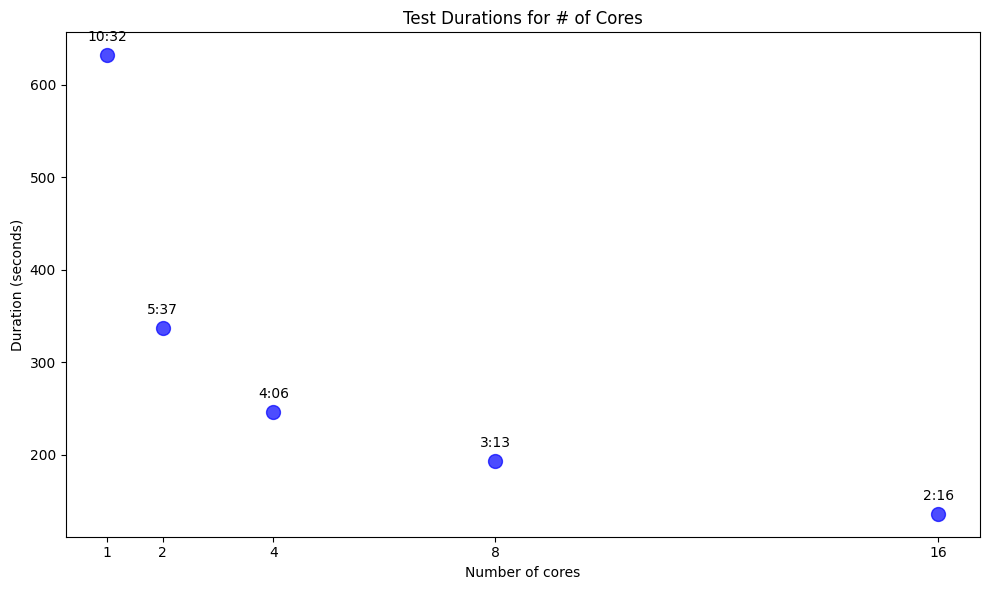

In [5]:
## iterate through cores

print('> Running tests with different number of cores...')
duration_data = {
    'title': '# of Cores',
    'tests': []
}
for core in config['cores']:
    test_duration = run_test(core_num=core)
    duration_data['tests'].append(test_duration)
fig = plot(duration_data, x_label='Number of cores', x_indices=config['cores'])
fig.savefig('cores_plot')

> Running tests with different number of nodes...
2025-03-11 08:41:19 - Starting test with | cores: 16 | nodes: 1 | data_portion: 1.0


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/11 08:41:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

2025-03-11 08:46:06 - Starting test with | cores: 16 | nodes: 2 | data_portion: 1.0


2025-03-11 08:51:40 - Starting test with | cores: 16 | nodes: 3 | data_portion: 1.0


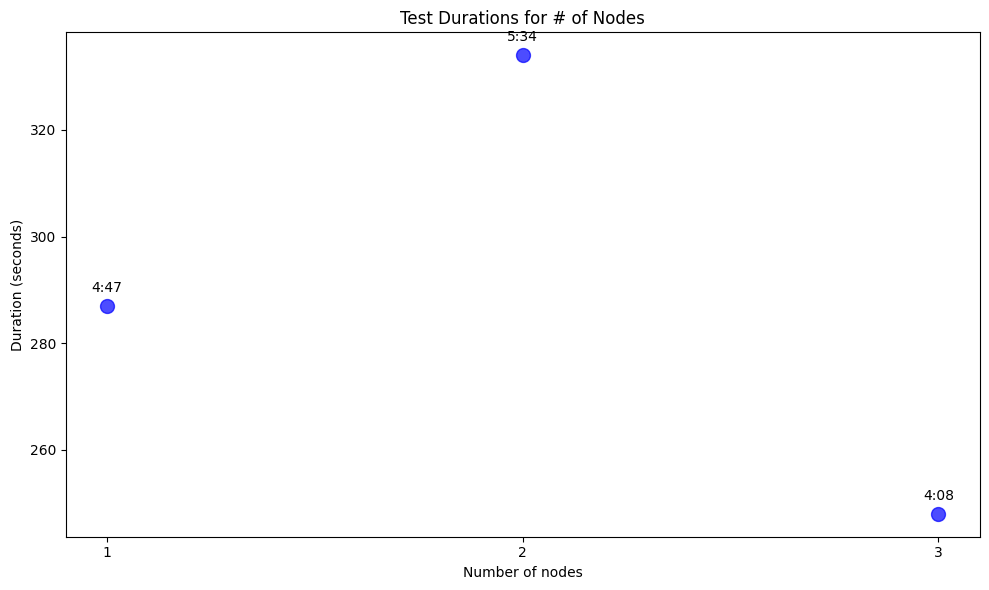

In [4]:
## iterate through nodes:

duration_data = {
    'title': '# of Nodes',
    'tests': []
}
print('> Running tests with different number of nodes...')
for node_num in config['nodes']:
    test_duration = run_test(node_num=node_num)
    duration_data['tests'].append(test_duration)
fig = plot(duration_data, x_label='Number of nodes', x_indices=config['nodes'])
fig.savefig('nodes_plot')

> Running tests with different data sizes...
2025-03-11 09:21:56 - Starting test with | cores: 16 | nodes: 3 | data_portion: 0.25


2025-03-11 09:25:49 - Starting test with | cores: 16 | nodes: 3 | data_portion: 0.5


2025-03-11 09:27:51 - Starting test with | cores: 16 | nodes: 3 | data_portion: 0.75


2025-03-11 09:30:50 - Starting test with | cores: 16 | nodes: 3 | data_portion: 1.0


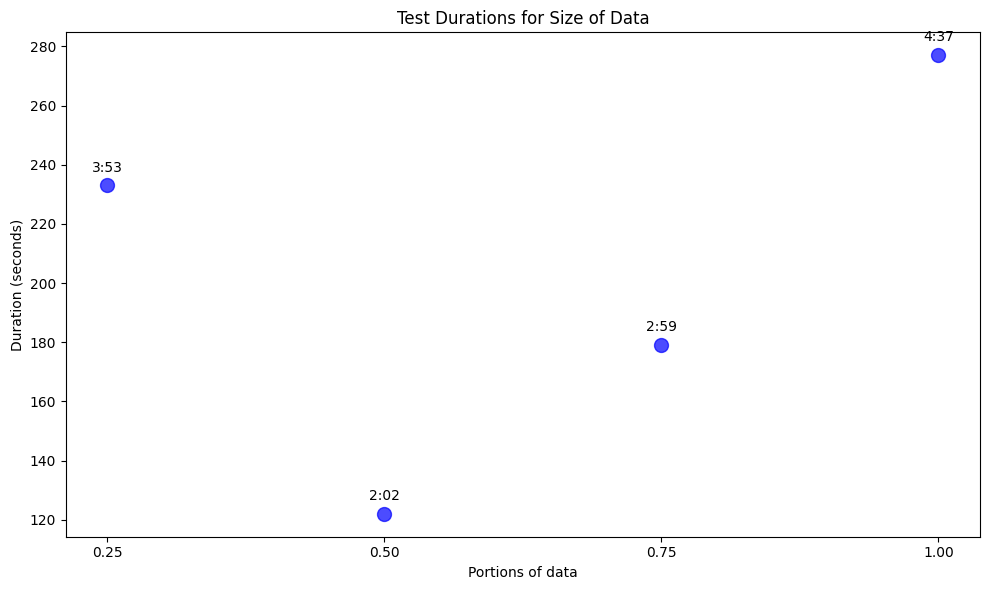

In [6]:
## iterate through data sizes

duration_data = {
    'title': 'Size of Data',
    'tests': []
}
print('> Running tests with different data sizes...')
for data_portion in config['data_portions']:
    test_duration = run_test(data_portion=data_portion)
    duration_data['tests'].append(test_duration)
fig = plot(duration_data, x_label='Portions of data', x_indices=config['data_portions'])    
fig.savefig('data_portions_plot')

> Running tests for weak scaling...
2025-03-11 09:35:27 - Starting test with | cores:  2 | nodes: 3 | data_portion: 0.25


2025-03-11 09:41:21 - Starting test with | cores:  4 | nodes: 3 | data_portion: 0.5


2025-03-11 09:44:25 - Starting test with | cores:  8 | nodes: 3 | data_portion: 1.0


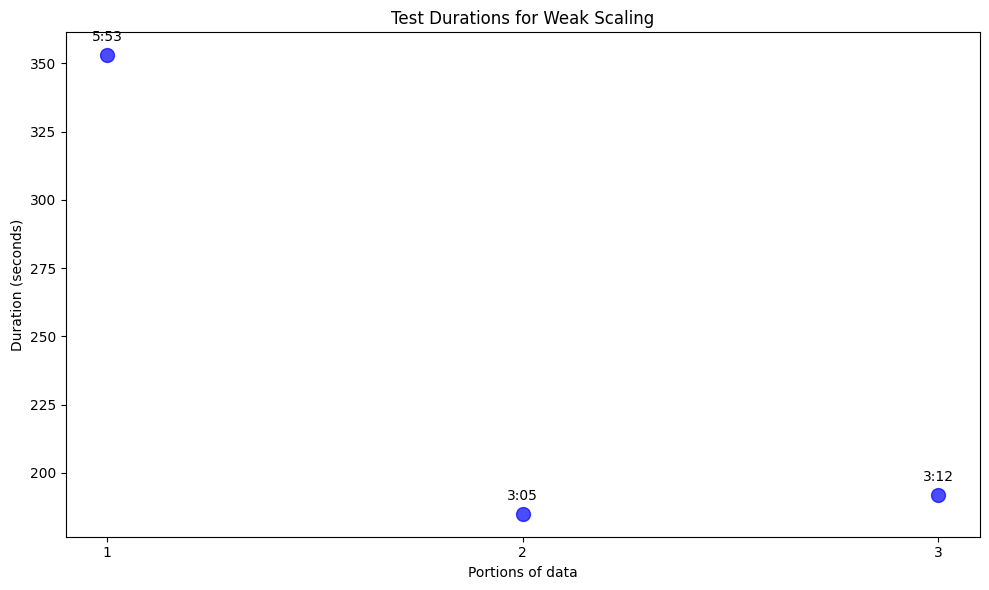

In [7]:
## weak scaling tests

duration_data = {
    'title': 'Weak Scaling',
    'tests': []
}
print('> Running tests for weak scaling...')

base_core_num = 2
base_data_portion = 0.25

for i in range(3):
    test_duration = run_test(core_num=base_core_num, data_portion=base_data_portion)
    duration_data['tests'].append(test_duration)

    base_core_num *= 2
    base_data_portion *= 2
    
fig = plot(duration_data, x_label='Portions of data')    
fig.savefig('weak_scaling_plot')